# Concrete Strength dataset 

This work is an analysis of the application of linear regression methods on concrete data. The goal is to predict the compressive strength of the concrete for some givern characteristics

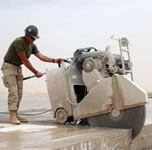

This dataset was provided by **I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)** and it's available at https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import power_transform, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

%matplotlib inline

def custom_describe(dataset):
    df = dataset.describe().T
    df = df.drop(columns=['count'])
    df['skewness'] = dataset.skew(axis=0).values
    df['maxmin_ratio'] = df['max']/df['min']
    return df

## Loading data and applying preprocessing steps

In [125]:
dataset = pd.read_csv('Concrete_Data_Yeh.csv')

df = custom_describe(dataset.drop(columns=['csMPa']))
df = df[df.maxmin_ratio > 20]
columns = df.index.values
df = dataset

for item in columns:
    df[item] = power_transform(df[item].values.reshape(-1,1), method='yeo-johnson').reshape(1,-1)[0]
    
df = df.drop(columns=['csMPa'])

scaler = StandardScaler()
scaler.fit(df)
data = scaler.transform(df)

for i, col in enumerate(df.columns):
    df[col] = data[:,i]

In [126]:
X = df
y = dataset['csMPa']

## Ordinary Linear Regression

In [130]:
", ".join(X.columns.tolist())

'cement, slag, flyash, water, superplasticizer, coarseaggregate, fineaggregate, age'

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training...")
reg = LinearRegression().fit(X_train, y_train)
print("Training done.\n")

print("Intercept: " + str(round(reg.intercept_, 2)))
print("Coefficients: " + str([round(i, 2) for i in reg.coef_]))

print("\n# TRAIN PERFORMANCE #")
train_rmse = mean_squared_error(y_train, reg.predict(X_train), squared = False)
train_r2 = r2_score(y_train, reg.predict(X_train))
print("RMSE: " + str(train_rmse))
print("R2: " + str(train_r2))

print("\n# TEST PERFORMANCE #")
test_rmse = mean_squared_error(y_test, reg.predict(X_test), squared = False)
test_r2 = r2_score(y_test, reg.predict(X_test))
print("RMSE: " + str(test_rmse))
print("R2: " + str(test_r2))

Training...
Training done.

Intercept: 35.75
Coefficients: [9.17, 5.54, 0.79, -4.38, 2.44, 0.12, -0.73, 10.08]

# TRAIN PERFORMANCE #
RMSE: 7.527201530876363
R2: 0.8005579833373279

# TEST PERFORMANCE #
RMSE: 6.818173201031577
R2: 0.8195900105279658


In [99]:
k = 10
print(f"\n# {k}-FOLD CV PERFORMANCE #")

kf = KFold(n_splits=k)

lr_kf_rmse = []
lr_kf_r2 = []
i = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    reg = LinearRegression().fit(X_train, y_train)
    
    test_rmse = mean_squared_error(y_test, reg.predict(X_test), squared = False)
    test_r2 = r2_score(y_test, reg.predict(X_test))
    
    print(f"\n  FOLD-{i}")
    print(f"   Test RMSE: {test_rmse}")
    print(f"   Test R2: {test_r2}")
    
    lr_kf_rmse.append(test_rmse)
    lr_kf_r2.append(test_r2)
    i+=1
    
print(f'''
Summary:
  {k}-fold Average RMSE: {np.mean(lr_kf_rmse)}
  {k}-fold Average R2: {np.mean(lr_kf_r2)}
''')


# 10-FOLD CV PERFORMANCE #

  FOLD-1
   Test RMSE: 9.572121524835733
   Test R2: 0.34060445189784117

  FOLD-2
   Test RMSE: 10.230438215562954
   Test R2: 0.7156630493581033

  FOLD-3
   Test RMSE: 6.950723440301143
   Test R2: 0.6736793047903467

  FOLD-4
   Test RMSE: 9.997500334473484
   Test R2: 0.6121717481828297

  FOLD-5
   Test RMSE: 8.537389609173877
   Test R2: 0.6288810522153532

  FOLD-6
   Test RMSE: 6.652099955737444
   Test R2: 0.7292391190558145

  FOLD-7
   Test RMSE: 4.747771998139583
   Test R2: 0.8693834302081663

  FOLD-8
   Test RMSE: 5.8542493009373375
   Test R2: 0.8545184452357154

  FOLD-9
   Test RMSE: 8.10713155903645
   Test R2: 0.590612856930435

  FOLD-10
   Test RMSE: 8.036705242779973
   Test R2: 0.5519811142593551

Summary:
  10-fold Average RMSE: 7.868613118097796
  10-fold Average R2: 0.6566734572133961



In [100]:
# df_results = pd.DataFrame({
#     "fold": [i for i in range(10)],
#     "RMSE": kf_rmse
# })

# sns.barplot(x='PC', y='Variance ratio', data=pca_data, color='b', ax=ax[0, 1])
# ax2 = ax[0, 1].twinx()
# sns.lineplot(x='PC', y='Cumulative variance ratio', data=pca_data, ax=ax2, color='r')

## Ridge regression (L2)

In [135]:
k = 10
kf = KFold(n_splits=k)

l2_10f_rmse = []
l2_10f_r2 = []
for alpha in np.linspace(5, 6, 10):
    print(f"Training with alpha = {alpha}...")
    
    l2_kf_rmse = []
    l2_kf_r2 = []
    i = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        reg = Ridge(alpha=alpha, random_state=4).fit(X_train, y_train)

        test_rmse = mean_squared_error(y_test, reg.predict(X_test), squared = False)
        test_r2 = r2_score(y_test, reg.predict(X_test))

        print(f"\n    FOLD-{i}")
        print(f"     RMSE: {test_rmse}")
        print(f"     R2: {test_r2}")
        print(f"Coefficients: {[round(i, 2) for i in reg.coef_]}")
        print(f"Intercept: {round(reg.intercept_, 2)}")

        l2_kf_rmse.append(test_rmse)
        l2_kf_r2.append(test_r2)
        i+=1

    print(f'''
  Summary:
    {k}-fold Average RMSE: {np.mean(l2_kf_rmse)}
    {k}-fold Average R2: {np.mean(l2_kf_r2)}
    Coefficients: {[round(i, 2) for i in reg.coef_]}
    Intercept: {round(reg.intercept_, 2)}
    ''')
    print("##############################################")
    
    l2_10f_rmse.append(l2_kf_rmse) 
    l2_10f_r2.append(l2_kf_r2) 
    



Training with alpha = 5.0...

    FOLD-1
     RMSE: 9.546850301139171
     R2: 0.3440815777396742
Coefficients: [9.44, 5.49, 0.78, -4.56, 2.73, 0.01, -0.98, 10.01]
Intercept: 36.03

    FOLD-2
     RMSE: 10.27606525891648
     R2: 0.7131211475446408
Coefficients: [9.1, 5.01, 1.81, -4.55, 1.53, -0.0, -0.71, 9.82]
Intercept: 35.34

    FOLD-3
     RMSE: 6.9136089184918115
     R2: 0.6771548859154397
Coefficients: [8.85, 5.45, 1.07, -5.76, 1.51, -0.37, -1.57, 9.95]
Intercept: 35.7

    FOLD-4
     RMSE: 10.01722062350365
     R2: 0.6106402397113465
Coefficients: [9.25, 5.5, 0.71, -3.7, 2.57, -0.06, -0.62, 9.71]
Intercept: 35.18

    FOLD-5
     RMSE: 8.3970894332343
     R2: 0.6409784784434405
Coefficients: [10.41, 6.07, 1.83, -4.16, 2.27, 0.44, -0.47, 9.6]
Intercept: 35.94

    FOLD-6
     RMSE: 6.641914723212674
     R2: 0.7300676247314142
Coefficients: [9.11, 5.59, 1.03, -4.76, 1.88, 0.28, -0.85, 10.06]
Intercept: 36.13

    FOLD-7
     RMSE: 4.712009857910232
     R2: 0.87134373313483

    FOLD-3
     RMSE: 6.909563720638882
     R2: 0.6775325729704134
Coefficients: [8.83, 5.43, 1.06, -5.76, 1.52, -0.37, -1.57, 9.94]
Intercept: 35.7

    FOLD-4
     RMSE: 10.019548748659735
     R2: 0.6104592346950628
Coefficients: [9.23, 5.49, 0.69, -3.71, 2.57, -0.07, -0.64, 9.7]
Intercept: 35.18

    FOLD-5
     RMSE: 8.383034819797517
     R2: 0.6421792959292403
Coefficients: [10.38, 6.04, 1.81, -4.17, 2.28, 0.43, -0.49, 9.59]
Intercept: 35.94

    FOLD-6
     RMSE: 6.640947200378177
     R2: 0.7301462607048691
Coefficients: [9.09, 5.57, 1.02, -4.76, 1.88, 0.27, -0.86, 10.05]
Intercept: 36.13

    FOLD-7
     RMSE: 4.70840889388996
     R2: 0.8715402987524155
Coefficients: [9.4, 5.26, 1.08, -4.29, 2.64, 0.34, -0.64, 10.0]
Intercept: 35.72

    FOLD-8
     RMSE: 5.814963464781488
     R2: 0.8564644462742965
Coefficients: [9.3, 5.3, 0.93, -4.25, 2.38, 0.4, -0.58, 10.27]
Intercept: 36.03

    FOLD-9
     RMSE: 8.16718184871369
     R2: 0.5845256573634767
Coefficients: [8.37, 4.83, 0

In [102]:
# sns.set_style("white")
# sns.set_context("paper", font_scale=1.5)

# data = dict()
# alpha_list = [j for j in np.linspace(0, 1, 10)]
# for i in range(10):
#     data[str(round(alpha_list[i], 2))] = l2_10f_rmse[i]

# data["fold"] = [i+1 for i in range(10)]

# data_df = pd.DataFrame(data).melt(id_vars="fold")
# data_df.columns = ["fold", "α", "RMSE"]

# data_df

# fig, ax = plt.subplots(figsize=(10, 5),)

# sns.lineplot(x="fold", y="RMSE",
#              hue="α", ax=ax,
#              data=data_df)

## Principal Components Regression

In [103]:
X = df

k = 10
kf = KFold(n_splits=k)

pca = PCA(n_components=7)
X = pd.DataFrame(pca.fit_transform(X))

pcr_kf_rmse = []
pcr_kf_r2 = []
for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        reg = LinearRegression().fit(X_train, y_train)

        test_rmse = mean_squared_error(y_test, reg.predict(X_test), squared = False)
        test_r2 = r2_score(y_test, reg.predict(X_test))

        print(f"\n    FOLD-{i}")
        print(f"     RMSE: {test_rmse}")
        print(f"     R2: {test_r2}")
        print(f"     Coefficients: {[round(i, 2) for i in reg.coef_]}")
        print(f"     Intercept: {round(reg.intercept_, 2)}")

        pcr_kf_rmse.append(test_rmse)
        pcr_kf_r2.append(test_r2)

print(f'''
    Summary:
        {k}-fold Average RMSE: {np.mean(pcr_kf_rmse)}
        {k}-fold Average R2: {np.mean(pcr_kf_r2)}
        ''')
print("##############################################")



    FOLD-11
     RMSE: 9.560969797194632
     R2: 0.3421399769341099
     Coefficients: [-0.68, 3.88, 6.68, -10.51, -0.68, -6.95, 4.64]
     Intercept: 36.01

    FOLD-11
     RMSE: 10.304492510561063
     R2: 0.7115317342458503
     Coefficients: [-0.68, 3.22, 5.88, -10.18, -1.03, -6.38, 5.81]
     Intercept: 35.31

    FOLD-11
     RMSE: 7.356566118855137
     R2: 0.6344600188562042
     Coefficients: [-0.65, 3.76, 6.37, -10.21, -0.43, -7.23, 6.02]
     Intercept: 35.66

    FOLD-11
     RMSE: 9.829020046933499
     R2: 0.6251331562482106
     Coefficients: [-0.34, 3.95, 6.38, -10.01, -0.99, -6.56, 4.43]
     Intercept: 35.2

    FOLD-11
     RMSE: 7.744086379427599
     R2: 0.6946462183132663
     Coefficients: [-0.69, 3.69, 6.77, -10.36, -0.49, -6.55, 5.47]
     Intercept: 35.83

    FOLD-11
     RMSE: 6.781076624327592
     R2: 0.7186378400519805
     Coefficients: [-0.46, 3.56, 6.2, -10.14, -0.72, -7.22, 5.48]
     Intercept: 36.18

    FOLD-11
     RMSE: 4.393970025585395
     

C:\Users\saulo_mendes\Anaconda3\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)
C:\Users\saulo_mendes\Anaconda3\lib\site-packages\seaborn\categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try barplot
  warnings.warn(msg, UserWarning)


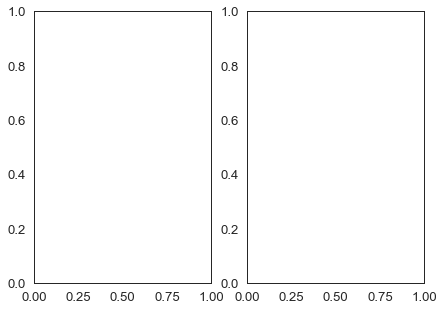

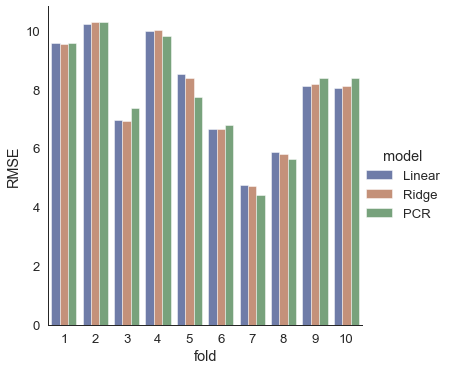

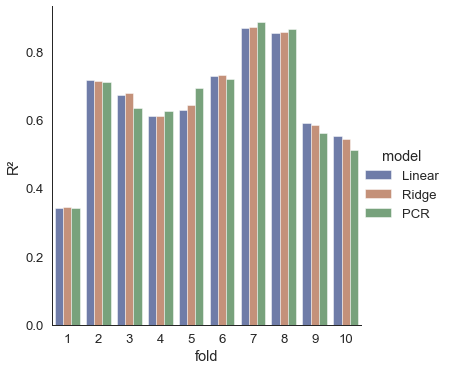

In [139]:
f, ax = plt.subplots(1, 2, figsize=(7, 5))

df = pd.DataFrame({
    "Linear": lr_kf_rmse,
    "Ridge": l2_kf_rmse,
    "PCR": pcr_kf_rmse, 
    "fold": [i+1 for i in range(10)]
}).melt(id_vars="fold")

df.columns = ["fold", "model", "RMSE"]

sns.catplot(
    data=df, kind="bar", ax=ax[0],
    x="fold", y="RMSE", hue="model", palette="dark", alpha=.6
)


df = pd.DataFrame({
    "Linear": lr_kf_r2,
    "Ridge": l2_kf_r2,
    "PCR": pcr_kf_r2, 
    "fold": [i+1 for i in range(10)]
}).melt(id_vars="fold")

df.columns = ["fold", "model", "R²"]


sns.catplot(
    data=df, kind="bar", ax=ax[1],
    x="fold", y="R²", hue="model", palette="dark", alpha=.6
)

In [138]:
ax

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000242B8511308>,
      dtype=object)